## Setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess

from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

import warnings

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


# Functions for generalization

In [3]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDist, minDiag, byDistance, balance, ooe):
    # minDist = minimun distance in kb to plot in APA
    # Load cool file
    cool_file = coolFileDir + '/' + coolFileName + '_KR.cool'
    clr = cooler.Cooler(f'{cool_file}')
    # Load loop file
    loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    # Load expected table
    exp_file = coolFileDir + '/' + coolFileName + '_KR_exp.tsv'
    exp_df = pd.read_csv(exp_file, delimiter='\t')

    # Pileup
    if ooe:
        pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = True, expected_df = exp_df)
    else:
         pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = False)       

    return pup

def get_corner_score(pup, flank = 1):
    amap = pup["data"][0]
    c = amap.shape[0] / (flank*2 + 1)
    c = int(c)
    central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
    topRight = np.nanmean(amap[:c, -c:])
    cornerScore = central/topRight
    return cornerScore, central, topRight, 


def drawAPA(pup, scale, colormap, vmax, vmin, fileDir, fileName):
    puptemp = copy.deepcopy(pup)
    if scale == 'log2':
        puptemp.data[0] = np.log2(puptemp.data[0])

    # Make figure
    # Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
    if vmax == False:
        fg1 = plotpup.plot(puptemp,
                           cmap = colormap,
                           score = False, 
                           scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    else:
        fg1 = plotpup.plot(puptemp,
                   cmap = colormap,
                   score = False, vmax = vmax, vmin = vmin,
                   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    file = fileDir + '/' + fileName + '.svg'
    fg1.savefig(file, format = 'svg')
    return True


# APA plot

In [5]:
# LOADING COOL FILE
coolDir = '/Volumes/UKJIN_SSD/MtoG1/data/cool_norm_pooled'
figDir = '/Volumes/UKJIN_SSD/MtoG1/figure/loop_analysis'
loopDir = '/Volumes/UKJIN_SSD/MtoG1/data/loop_analysis'



## Chromosight vs FitHiC vs HiCDC+

python(55507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55509) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55517) Malloc

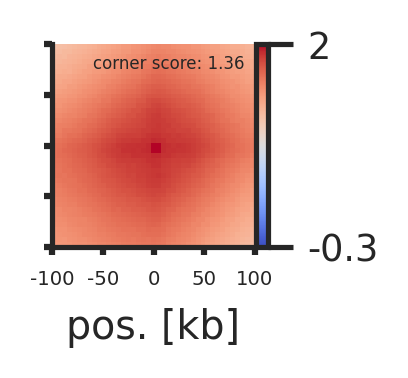

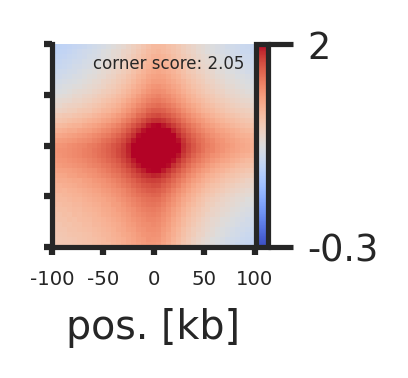

In [18]:
res = 5000
# vminmax_map = {
#     'UP':   (1, -0.3),
#     'NO':   (1, -0.3),
#     'DOWN': (1, -0.3),
# }

set = "loopOverlap"
# for name in ['Chromosight_unique']:
# for name in ['Chromosight_unique', 'Chromosight_overlap']:
for name in ['HiCDCP_unique', 'HiCDCP_overlap']:
# for name in ['FitHiC_unique', 'FitHiC_overlap']:
   
    vmax, vmin = 2, -0.3
    for sample in ['G1DMSO_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))


python(38455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38465) Malloc

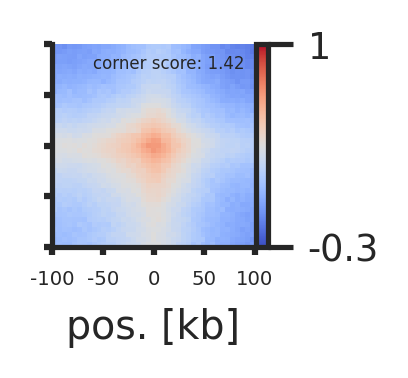

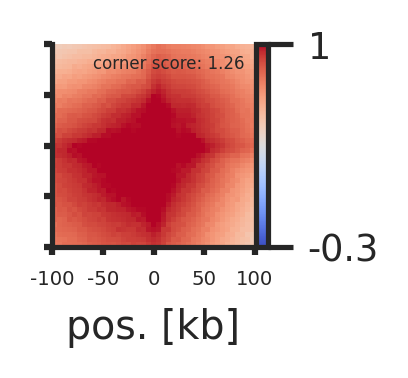

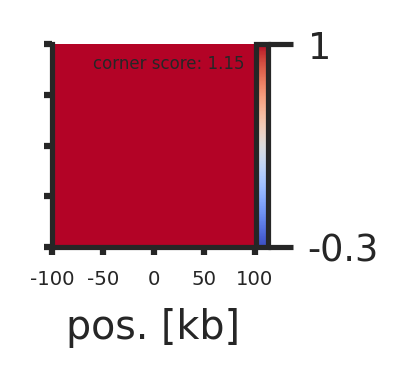

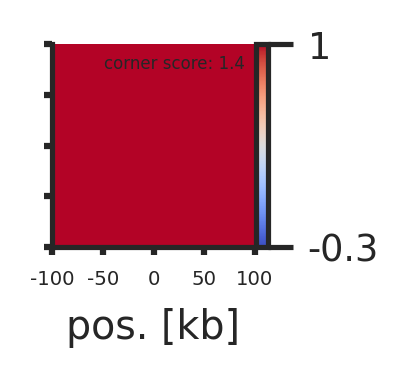

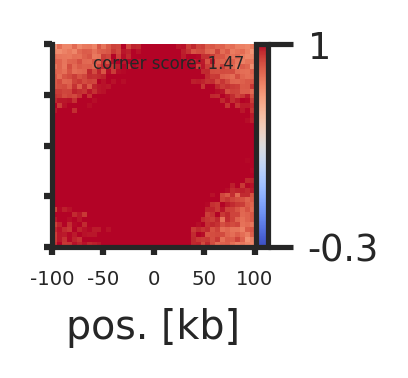

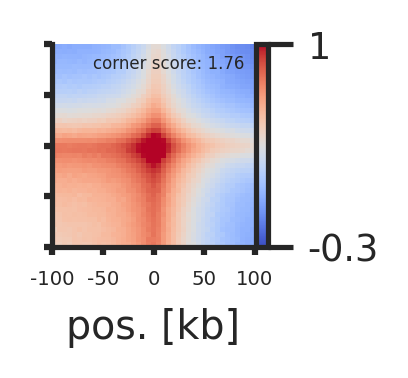

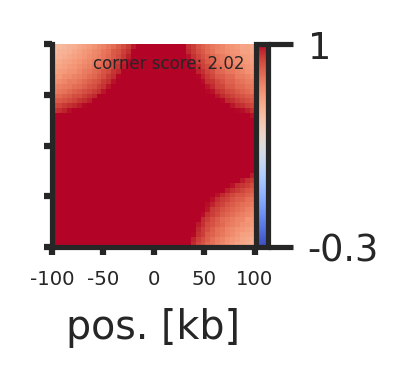

In [10]:
res = 5000
# vminmax_map = {
#     'UP':   (1, -0.3),
#     'NO':   (1, -0.3),
#     'DOWN': (1, -0.3),
# }

set = "loopOverlap"
# for name in ['Chromosight_unique']:
for name in ['Chromosight_unique', 'FitHiC_unique', 'HiCDCP_unique', 'HiCDCP_FitHiC', 'Chromosight_HiCDCP', 'Chromosight_FitHiC', 'Chromosight_HiCDCP_FitHiC']:
    vmax, vmin = 1, -0.3
    for sample in ['G1DMSO_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))


### Chromosight loops UP/NO/DOWN 

#### All loops

python(47686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47696) Malloc

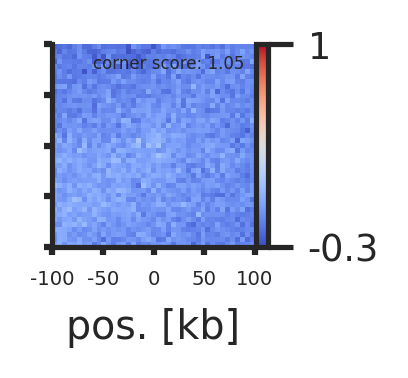

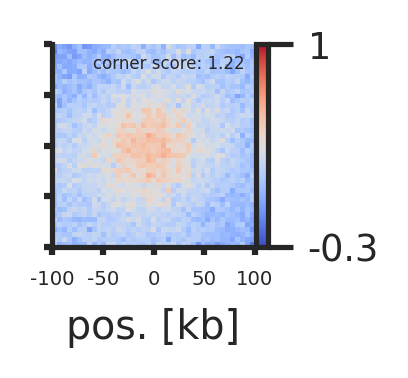

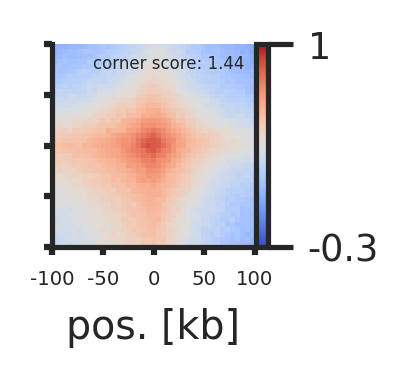

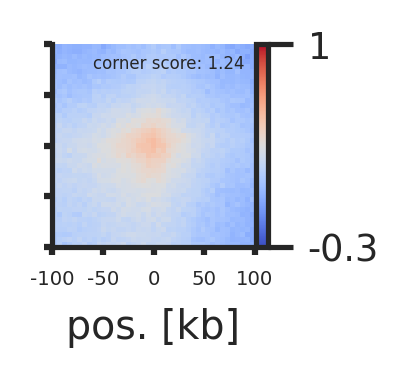

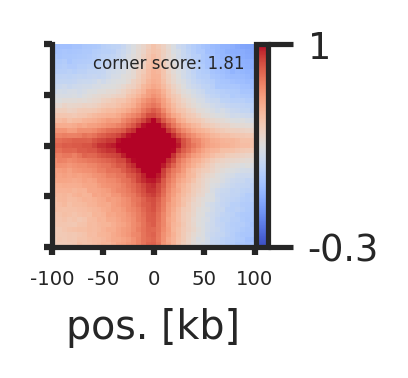

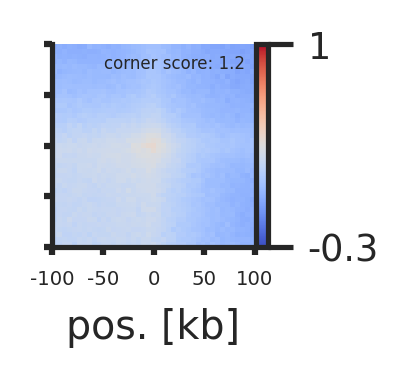

In [13]:
res = 5000
vminmax_map = {
    'UP':   (1, -0.3),
    'NO':   (1, -0.3),
    'DOWN': (1, -0.3),
}

set = "chromosight_score_all_dTAGvsDMSO_diffCutoff0.2"
for name in ['UP', 'NO', 'DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))

# vminmax_tests_no = [
#     (1.2, -0.3),
#     (1.2, -0.1),
#     (1, -0.3)
# ]

# #for name in ['UP', 'NO', 'DOWN']:
# set = "chromosight_score_all_dTAGvsDMSO_diffCutoff0.2"
# name = 'NO'
# vmax, vmin = vminmax_map[name]
# for vmax, vmin in vminmax_tests_no:
# 	for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
# 		pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
# 								loopDir, set + '_' + name,
# 								minDist = 50, minDiag = 21, byDistance = False,
# 								balance = 'weight', ooe = True)
# 		fileName = 'APA_' + set + "_" + name + '_' + sample
# 		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
# 				fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))


#### Str loops

python(42779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42789) Malloc

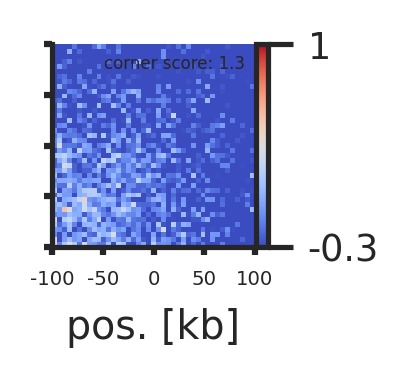

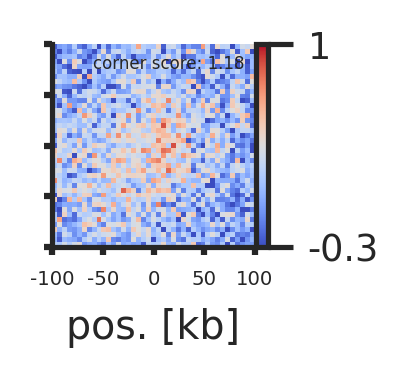

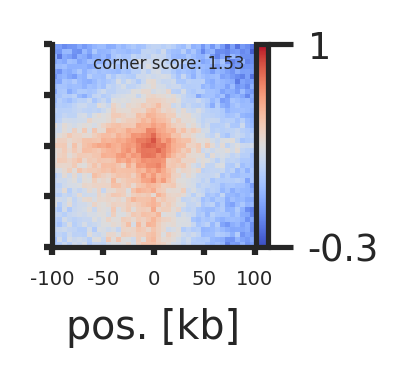

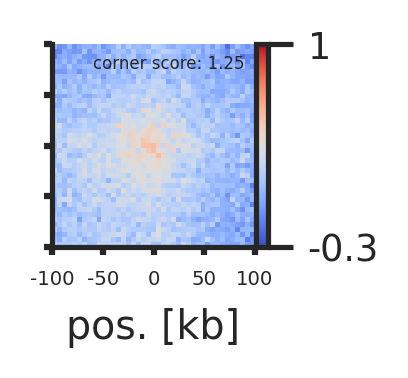

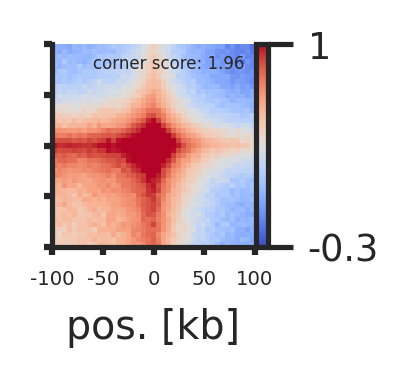

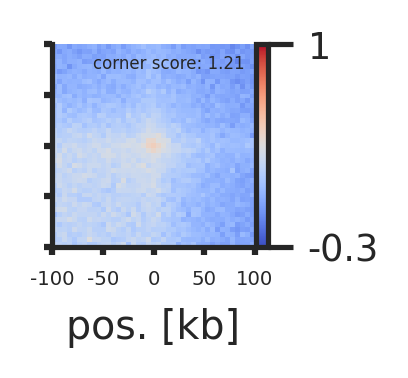

In [11]:
res = 5000
vminmax_map = {
    'UP':   (1, -0.3),
    'NO':   (1, -0.3),
    'DOWN': (1, -0.3),
}

set = "chromosight_score_complex_str_dTAGvsDMSO_diffCutoff0.2"
for name in ['UP', 'NO', 'DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))

#### Res loops

python(41491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41501) Malloc

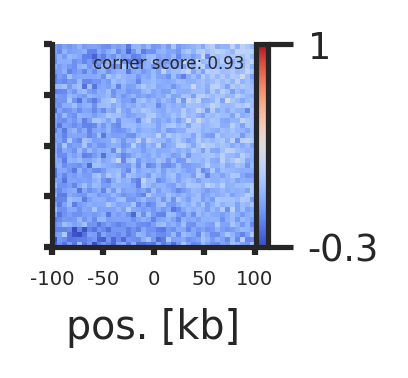

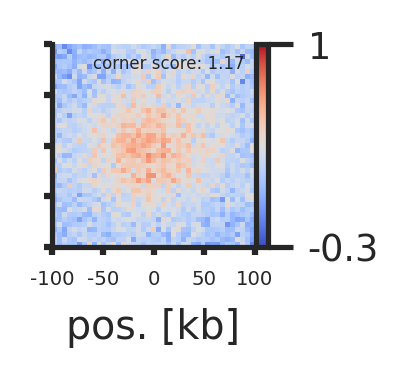

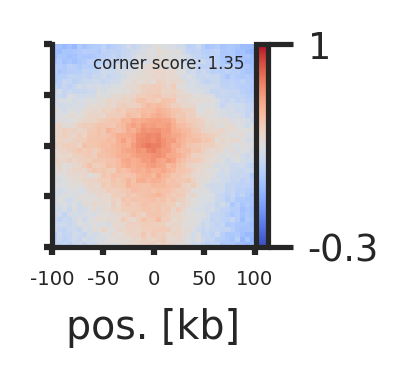

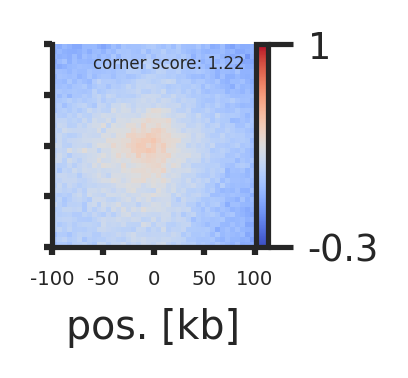

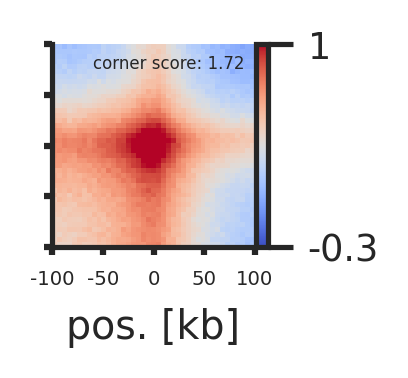

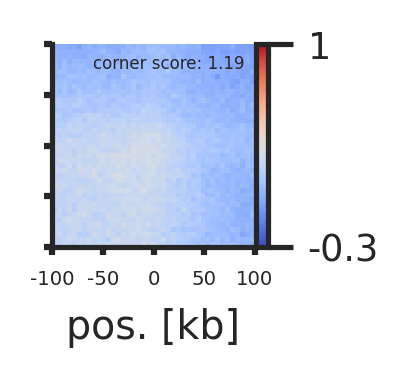

In [10]:
res = 5000
vminmax_map = {
    'UP':   (1, -0.3),
    'NO':   (1, -0.3),
    'DOWN': (1, -0.3),
}

set = "chromosight_score_complex_reg_dTAGvsDMSO_diffCutoff0.2"
for name in ['UP', 'NO', 'DOWN']:
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))

### Insulation domain

In [15]:
res = 5000
vminmax_map = {
    'no':   (0.8, -0.3),
    'within':   (0.5, -0.3),
    'outside': (0.5, -0.3),
}

set = "insulated_domain_ESC_ss"
#for name in ['no', 'within', 'outside']:
for name in ['no']:
    
    vmax, vmin = vminmax_map[name]
    for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                              loopDir, set + '_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + set + "_" + name + '_' + sample
        # drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
        #        fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
                fileDir = figDir, fileName = fileName + '_vminmax_' + str(vmax) + '_' + str(vmin))

FileNotFoundError: [Errno 2] No such file or directory

### EXPLORATORY

INFO:coolpuppy:('chr12', 'chr12'): 200
INFO:coolpuppy:('chr9', 'chr9'): 220
INFO:coolpuppy:('chr8', 'chr8'): 189
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 204
INFO:coolpuppy:('chr6', 'chr6'): 225
INFO:coolpuppy:('chr5', 'chr5'): 210
INFO:coolpuppy:('chr4', 'chr4'): 228
INFO:coolpuppy:('chr3', 'chr3'): 256
INFO:coolpuppy:('chr15', 'chr15'): 152
INFO:coolpuppy:('chr16', 'chr16'): 151
INFO:coolpuppy:('chr19', 'chr19'): 114
INFO:coolpuppy:('chr13', 'chr13'): 192
INFO:coolpuppy:('chr18', 'chr18'): 148
INFO:coolpuppy:('chrX', 'chrX'): 125
INFO:coolpuppy:('chr14', 'chr14'): 182
INFO:coolpuppy:('chr17', 'chr17'): 130
INFO:coolpuppy:('chr1', 'chr1'): 331
INFO:coolpuppy:('chr2', 'chr2'): 332
INFO:coolpuppy:('chr11', 'chr11'): 282
INFO:coolpuppy:Total number of piled up windows: 4091
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 200
INFO:coolpuppy:('chr9', 'chr9'): 220
INFO:coolpuppy

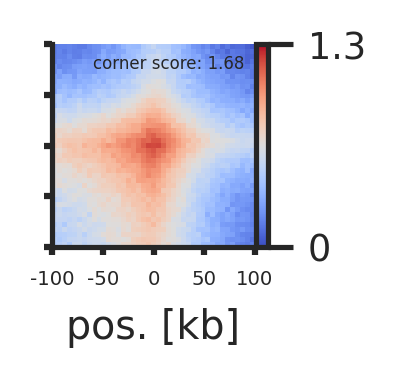

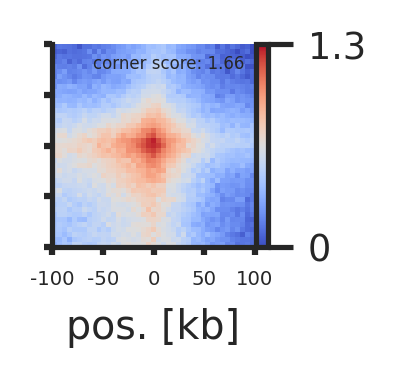

In [6]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (1.3, 0)
name = 'temp_EpiLCDMSO_onlyCalled'
for sample in ['G1DMSO_pooled', 'EpiG1DMSO_pooled']:
	pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
							loopDir, name,
							minDist = 50, minDiag = 21, byDistance = False,
							balance = 'weight', ooe = True)
	fileName = "APA_" + name + '_' + sample
	# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
	#        fileDir = figDir, fileName = fileName)
	drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
			fileDir = figDir, fileName = fileName + '_vminmax')

python(35465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35476) Malloc

KeyboardInterrupt: 

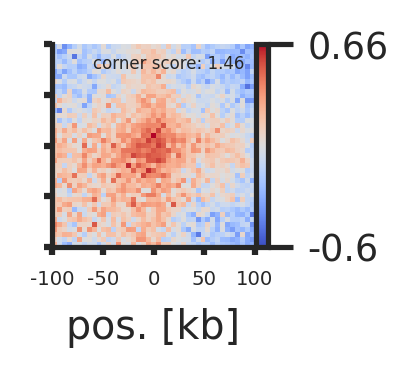

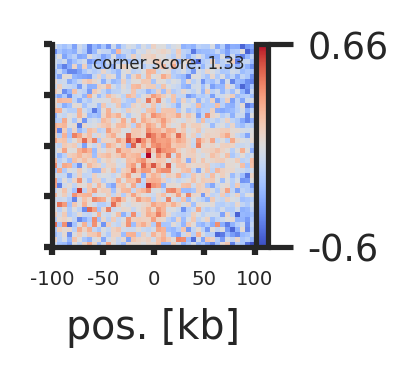

In [ ]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (0.66, -0.6)
# for name in ['temp_loop_reg_epi', 'temp_loop_reg_esc', 'temp_loop_str_epi', 'temp_loop_str_esc']:
for name in ['temp_loop_reg_epi' ]:
	for sample in ['G1DMSO_pooled', 'EpiG1DMSO_pooled', 'G1dTAG_pooled', 'EpiG1dTAG_pooled']:
		pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
								loopDir, name,
								minDist = 50, minDiag = 21, byDistance = False,
								balance = 'weight', ooe = True)
		fileName = "APA_" + name + '_' + sample
		# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
		# 	fileDir = figDir, fileName = fileName)
		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
				fileDir = figDir, fileName = fileName + '_vminmax')

INFO:coolpuppy:('chr12', 'chr12'): 23
INFO:coolpuppy:('chr8', 'chr8'): 17
INFO:coolpuppy:('chr10', 'chr10'): 59
INFO:coolpuppy:('chr7', 'chr7'): 31
INFO:coolpuppy:('chr9', 'chr9'): 31
INFO:coolpuppy:('chr4', 'chr4'): 33
INFO:coolpuppy:('chr5', 'chr5'): 60
INFO:coolpuppy:('chr6', 'chr6'): 40
INFO:coolpuppy:('chr3', 'chr3'): 47
INFO:coolpuppy:('chr11', 'chr11'): 72
INFO:coolpuppy:('chr2', 'chr2'): 42
INFO:coolpuppy:('chr1', 'chr1'): 55
INFO:coolpuppy:('chr13', 'chr13'): 38
INFO:coolpuppy:('chr18', 'chr18'): 33
INFO:coolpuppy:('chr19', 'chr19'): 17
INFO:coolpuppy:('chr16', 'chr16'): 21
INFO:coolpuppy:('chr15', 'chr15'): 43
INFO:coolpuppy:('chrX', 'chrX'): 16
INFO:coolpuppy:('chr14', 'chr14'): 24
INFO:coolpuppy:('chr17', 'chr17'): 28
INFO:coolpuppy:Total number of piled up windows: 730
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 23
INFO:coolpuppy:('chr10', 'chr10'): 59
INFO:coolpuppy:('chr9', 'chr9'): 31

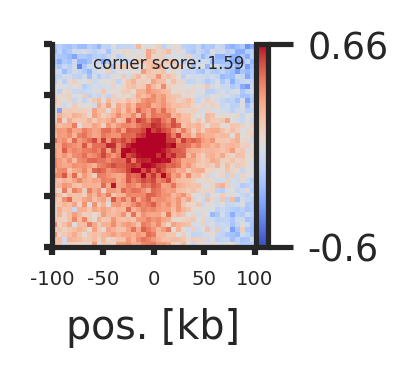

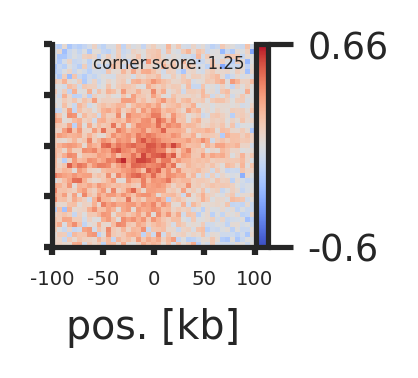

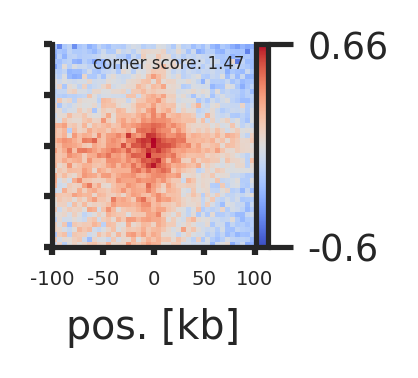

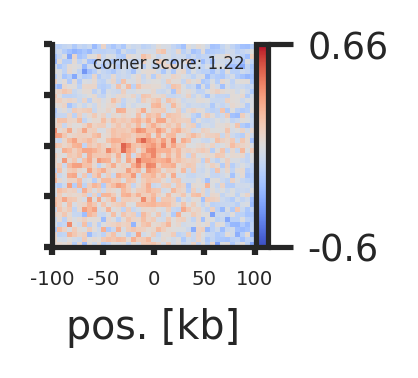

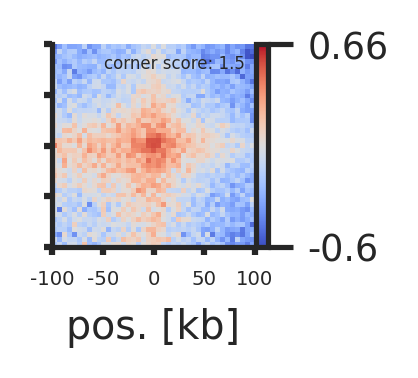

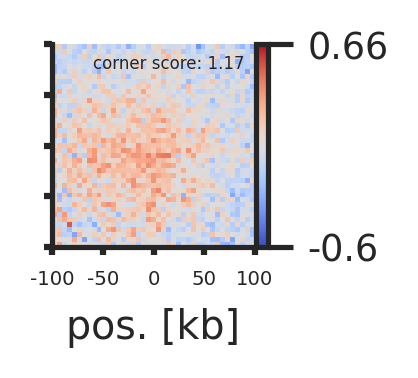

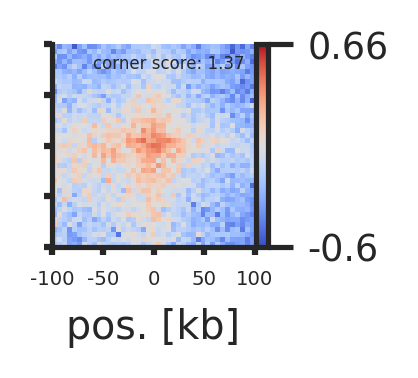

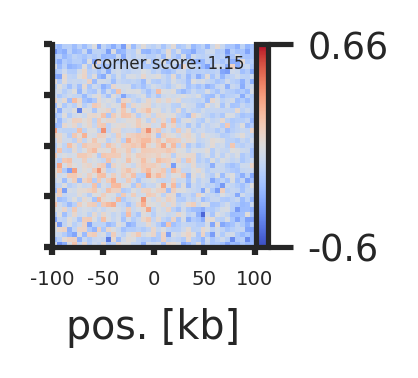

In [25]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (0.66, -0.6)
# for name in ['temp_loop_reg_epi', 'temp_loop_reg_esc', 'temp_loop_str_epi', 'temp_loop_str_esc']:
for name in ['temp_loop_epi', 'temp_loop_esc']:
	for sample in ['G1DMSO_pooled_5000bp_downsampled-589M', 'G1dTAG_pooled_5000bp_downsampled-589M', 'EpiG1DMSO_pooled_5000bp', 'EpiG1dTAG_pooled_5000bp']:
		pup = callAPAoverLoop(coolDir, sample,
								loopDir, name,
								minDist = 50, minDiag = 21, byDistance = False,
								balance = 'weight', ooe = True)
		fileName = "APA_" + name + '_' + sample
		# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
		# 	fileDir = figDir, fileName = fileName)
		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
				fileDir = figDir, fileName = fileName + '_vminmax')

INFO:coolpuppy:('chr12', 'chr12'): 264
INFO:coolpuppy:('chr9', 'chr9'): 309
INFO:coolpuppy:('chr10', 'chr10'): 278
INFO:coolpuppy:('chr8', 'chr8'): 299
INFO:coolpuppy:('chr7', 'chr7'): 285
INFO:coolpuppy:('chr4', 'chr4'): 270
INFO:coolpuppy:('chr5', 'chr5'): 328
INFO:coolpuppy:('chr6', 'chr6'): 326
INFO:coolpuppy:('chr3', 'chr3'): 333
INFO:coolpuppy:('chr2', 'chr2'): 466
INFO:coolpuppy:('chr11', 'chr11'): 265
INFO:coolpuppy:('chr1', 'chr1'): 454
INFO:coolpuppy:('chr19', 'chr19'): 154
INFO:coolpuppy:('chr13', 'chr13'): 258
INFO:coolpuppy:('chrX', 'chrX'): 194
INFO:coolpuppy:('chr14', 'chr14'): 253
INFO:coolpuppy:('chr17', 'chr17'): 191
INFO:coolpuppy:('chr18', 'chr18'): 209
INFO:coolpuppy:('chr16', 'chr16'): 198
INFO:coolpuppy:('chr15', 'chr15'): 223
INFO:coolpuppy:Total number of piled up windows: 5557
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 264
INFO:coolpuppy:('chr9', 'chr9'): 309
INFO:coolpuppy

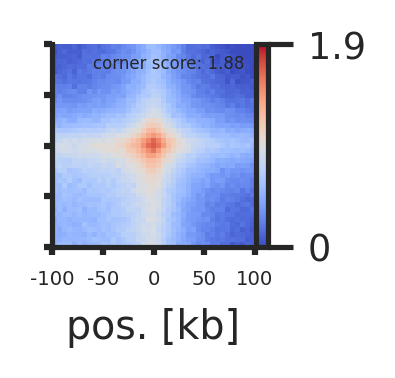

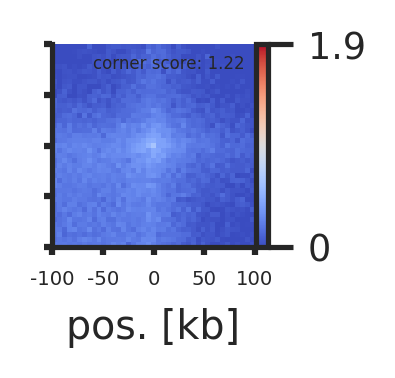

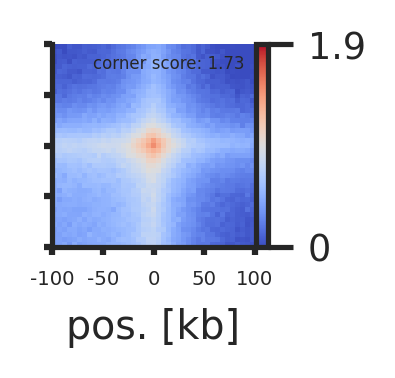

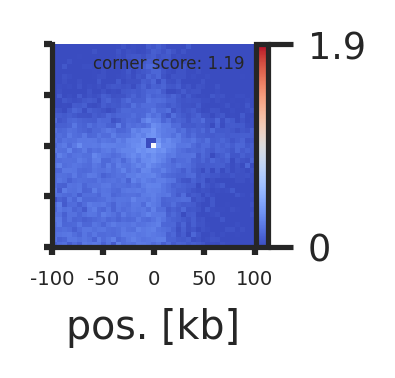

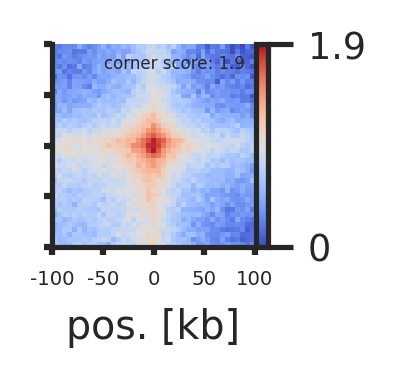

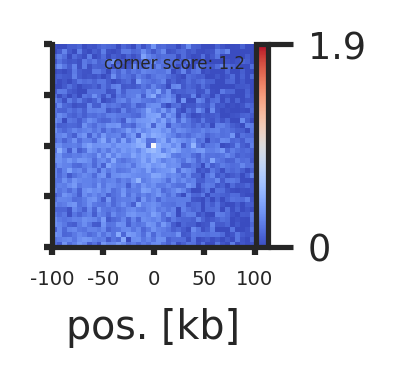

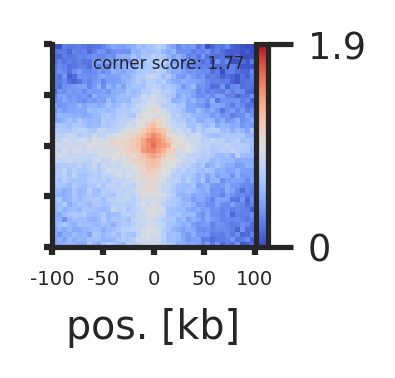

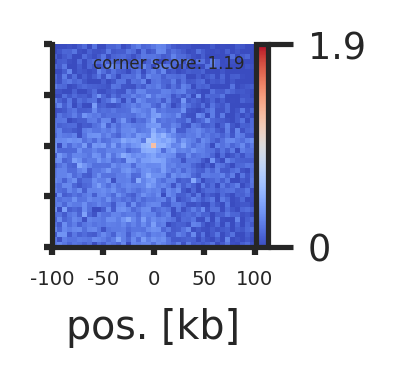

In [6]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (1.9, 0)
# for name in ['temp_loop_reg_epi', 'temp_loop_reg_esc', 'temp_loop_str_epi', 'temp_loop_str_esc']:
for name in ['loop_fcCluster_EpiLCspecificPerturb', 'loop_fcCluster_ESCspecificPerturb']:
	for sample in ['G1DMSO_pooled_5000bp_downsampled-589M', 'G1dTAG_pooled_5000bp_downsampled-589M', 'EpiG1DMSO_pooled_5000bp', 'EpiG1dTAG_pooled_5000bp']:
		pup = callAPAoverLoop(coolDir, sample,
								loopDir, name,
								minDist = 50, minDiag = 21, byDistance = False,
								balance = 'weight', ooe = True)
		fileName = "APA_" + name + '_' + sample
		# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
		# 	fileDir = figDir, fileName = fileName)
		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
				fileDir = figDir, fileName = fileName + '_vminmax')

INFO:coolpuppy:('chr12', 'chr12'): 365
INFO:coolpuppy:('chr4', 'chr4'): 435
INFO:coolpuppy:('chr10', 'chr10'): 418
INFO:coolpuppy:('chr8', 'chr8'): 414
INFO:coolpuppy:('chr9', 'chr9'): 428
INFO:coolpuppy:('chr7', 'chr7'): 468
INFO:coolpuppy:('chr6', 'chr6'): 441
INFO:coolpuppy:('chr3', 'chr3'): 456
INFO:coolpuppy:('chr5', 'chr5'): 464
INFO:coolpuppy:('chr2', 'chr2'): 601
INFO:coolpuppy:('chr1', 'chr1'): 544
INFO:coolpuppy:('chr11', 'chr11'): 452
INFO:coolpuppy:('chr15', 'chr15'): 319
INFO:coolpuppy:('chr13', 'chr13'): 351
INFO:coolpuppy:('chr19', 'chr19'): 186
INFO:coolpuppy:('chr16', 'chr16'): 282
INFO:coolpuppy:('chr18', 'chr18'): 269
INFO:coolpuppy:('chrX', 'chrX'): 179
INFO:coolpuppy:('chr17', 'chr17'): 290
INFO:coolpuppy:('chr14', 'chr14'): 322
INFO:coolpuppy:Total number of piled up windows: 7684
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 365
INFO:coolpuppy:('chr8', 'chr8'): 414
INFO:coolpuppy

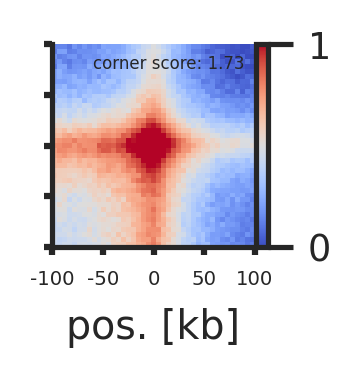

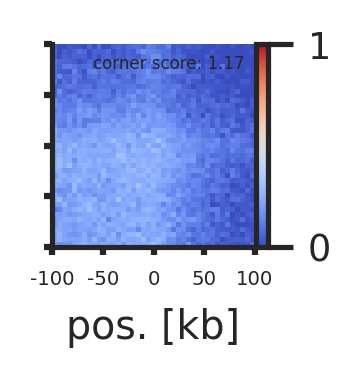

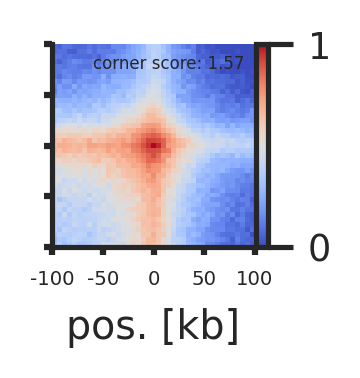

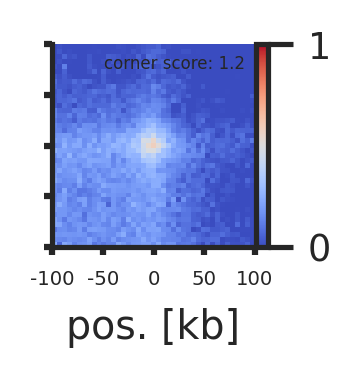

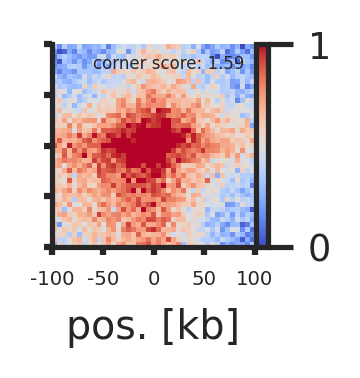

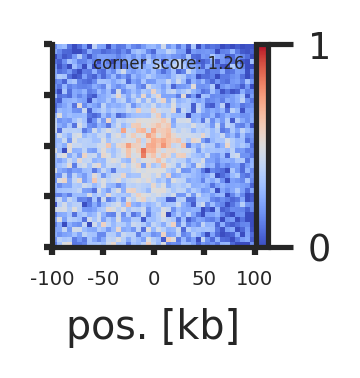

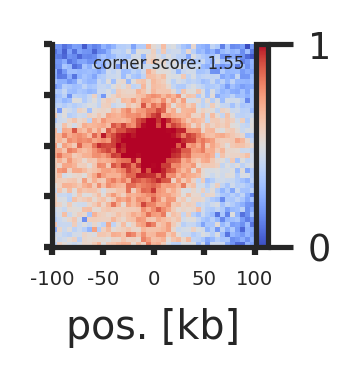

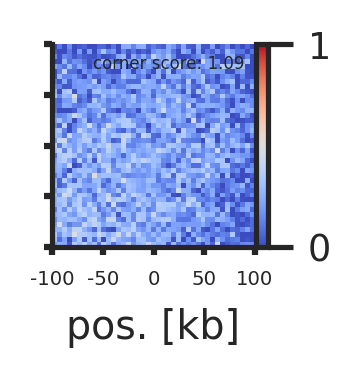

In [10]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (1.0, 0)
# for name in ['temp_loop_reg_epi', 'temp_loop_reg_esc', 'temp_loop_str_epi', 'temp_loop_str_esc']:
for name in ['loop_deltaScore_ESCspecificPerturb', 'loop_deltaScore_EpiLCspecificPerturb']:
	for sample in ['G1DMSO_pooled_5000bp_downsampled-589M', 'G1dTAG_pooled_5000bp_downsampled-589M', 'EpiG1DMSO_pooled_5000bp', 'EpiG1dTAG_pooled_5000bp']:
		pup = callAPAoverLoop(coolDir, sample,
								loopDir, name,
								minDist = 50, minDiag = 21, byDistance = False,
								balance = 'weight', ooe = True)
		fileName = "APA_" + name + '_' + sample
		# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
		# 	fileDir = figDir, fileName = fileName)
		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
				fileDir = figDir, fileName = fileName + '_vminmax')

INFO:coolpuppy:('chr12', 'chr12'): 466
INFO:coolpuppy:('chr9', 'chr9'): 496
INFO:coolpuppy:('chr8', 'chr8'): 525
INFO:coolpuppy:('chr10', 'chr10'): 532
INFO:coolpuppy:('chr7', 'chr7'): 495
INFO:coolpuppy:('chr6', 'chr6'): 616
INFO:coolpuppy:('chr4', 'chr4'): 595
INFO:coolpuppy:('chr5', 'chr5'): 555
INFO:coolpuppy:('chr3', 'chr3'): 665
INFO:coolpuppy:('chr13', 'chr13'): 458
INFO:coolpuppy:('chr19', 'chr19'): 222
INFO:coolpuppy:('chr11', 'chr11'): 502
INFO:coolpuppy:('chr1', 'chr1'): 613
INFO:coolpuppy:('chr16', 'chr16'): 420
INFO:coolpuppy:('chr2', 'chr2'): 765
INFO:coolpuppy:('chr15', 'chr15'): 388
INFO:coolpuppy:('chrX', 'chrX'): 320
INFO:coolpuppy:('chr17', 'chr17'): 378
INFO:coolpuppy:('chr18', 'chr18'): 362
INFO:coolpuppy:('chr14', 'chr14'): 459
INFO:coolpuppy:Total number of piled up windows: 9832
INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical
INFO:coolpuppy:('chr12', 'chr12'): 466
INFO:coolpuppy:('chr8', 'chr8'): 525
INFO:coolpuppy

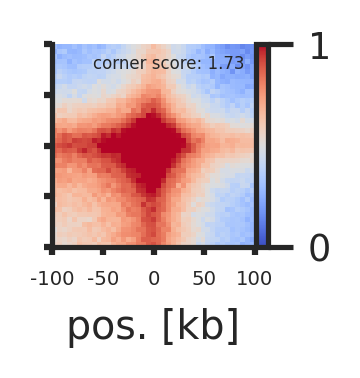

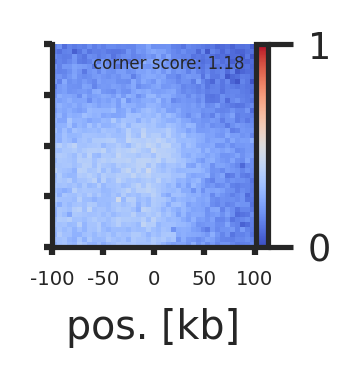

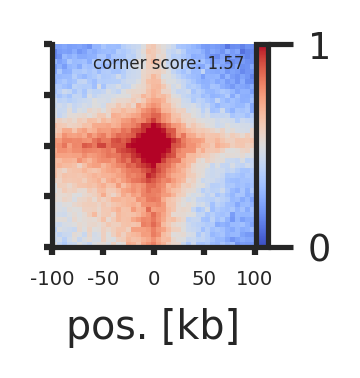

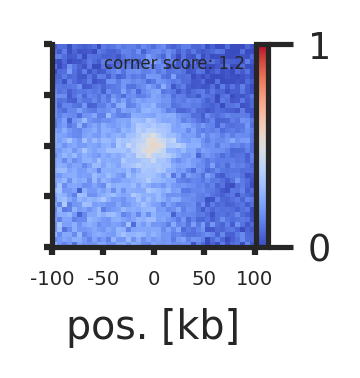

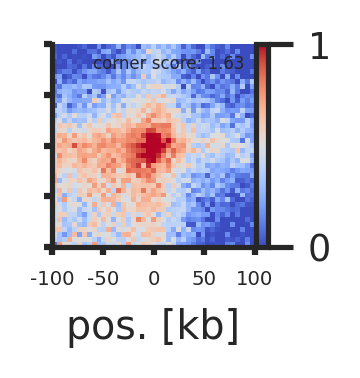

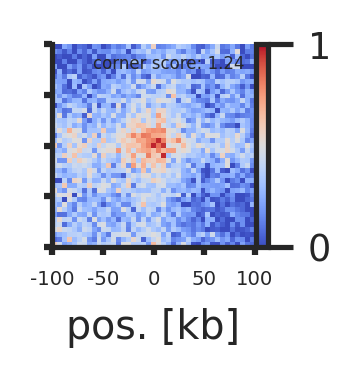

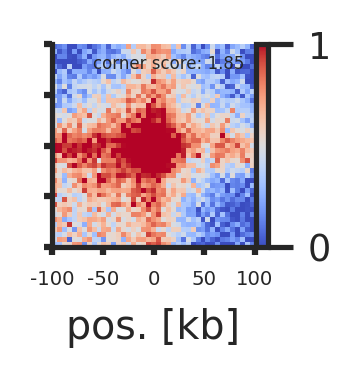

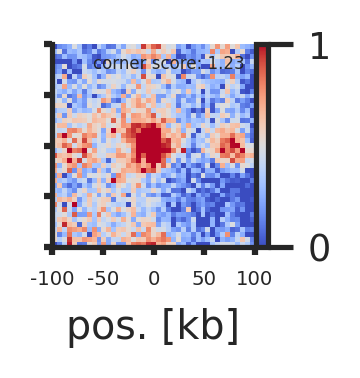

In [7]:
res = 5000

#for name in ['UP', 'NO', 'DOWN']:
vmax, vmin = (1, 0)
# for name in ['temp_loop_reg_epi', 'temp_loop_reg_esc', 'temp_loop_str_epi', 'temp_loop_str_esc']:
for name in ['loop_deltaScore_G1specificPerturb', 'loop_deltaScore_AsyncspecificPerturb']:
	for sample in ['G1DMSO_pooled_5000bp_downsampled-589M', 'G1dTAG_pooled_5000bp_downsampled-589M',
				'GSE178982_AsyncUT_pooled_5000bp_downsampled-589M', 'GSE178982_AsyncAID_pooled_5000bp_downsampled-589M']:
		pup = callAPAoverLoop(coolDir, sample,
								loopDir, name,
								minDist = 50, minDiag = 21, byDistance = False,
								balance = 'weight', ooe = True)
		fileName = "APA_" + name + '_' + sample
		# drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = False, vmin = False,
		# 	fileDir = figDir, fileName = fileName)
		drawAPA(pup, scale = 'log2', colormap = 'coolwarm', vmax = vmax, vmin = vmin,
				fileDir = figDir, fileName = fileName + '_vminmax')